In [1]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/Users/sunny/Desktop/Project/Dataset/chest_xray/chest_xray'

# Create a DataFrame from the list of files in the directory
files = os.listdir(path)
df = pd.DataFrame(files, columns=['Files'])

# Print the DataFrame
print(df)

       Files
0  .DS_Store
1       test
2      train
3        val


In [3]:
dict_ = {'train': [], 'test': [], 'val': []}

# Populate the dictionary with image counts
for i in tqdm(['train', 'test', 'val']):
    path_ = os.path.join(path, i)
    for j in os.listdir(path_):
        subpath = os.path.join(path_, j)
        # Check if the current item is a directory
        if os.path.isdir(subpath):
            # Count the number of images within the subdirectory
            dict_[i].append(len(os.listdir(subpath)))

# Create a DataFrame from the dictionary
df = pd.concat({k: pd.Series(v) for k, v in dict_.items()}, axis=1)

# Display the DataFrame
print(df)


100%|██████████| 3/3 [00:00<00:00, 581.60it/s]

   train  test  val
0   3876   390    9
1   1342   234    9


In [4]:
#Size
def Size(folder):
    #Initialize an empty list to store the sizes of the images
    size=[]
    #Join the input folder name with the current working directory
    path_=os.path.join(path,folder)
    #Iterate over all the files and directories in the folder
    for i in tqdm(os.listdir(path_)):
        #Get the path to the current file or directory
        path2=os.path.join(path_,i)
        #If the current file or directory is a directory, iterate over all the files in that directory
        if os.path.isdir(path2):
            for j in os.listdir(path2):
                #Read the image file
                img=cv2.imread(os.path.join(path2,j))
                #Append the shape of the image to the size list
                size.append(img.shape)
    #Convert the size list into a pandas Series and return it
    return pd.Series(size)

In [5]:
# Define the Size function
def Size(folder):
    # Initialize an empty list to store the sizes of the images
    size = []
    # Join the input folder name with the current working directory
    path_ = os.path.join(path, folder)
    # Iterate over all the files and directories in the folder
    for i in tqdm(os.listdir(path_)):
        # Get the path to the current file or directory
        path2 = os.path.join(path_, i)
        # Check if the current item is a directory
        if os.path.isdir(path2):
            # If it is, iterate over all the files in that directory
            for j in os.listdir(path2):
                # Read the image file
                img_path = os.path.join(path2, j)
                # Ensure the file is an image
                if j.endswith(('.png', '.jpg', '.jpeg')):
                    try:
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Append the shape of the image to the size list
                            size.append(img.shape)
                        else:
                            print(f"Warning: Could not read image {img_path}")
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")
                else:
                    print(f"Skipping non-image file: {img_path}")
    # Convert the size list into a pandas Series and return it
    return pd.Series(size)

# Calculating the size of train images
train_image_sizes = Size('train')
print(train_image_sizes)

  0%|          | 0/3 [00:00<?, ?it/s]

Skipping non-image file: /Users/sunny/Desktop/Project/Dataset/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store


 67%|██████▋   | 2/3 [00:12<00:06,  6.49s/it]

Skipping non-image file: /Users/sunny/Desktop/Project/Dataset/chest_xray/chest_xray/train/NORMAL/.DS_Store


100%|██████████| 3/3 [00:31<00:00, 10.35s/it]

0        (736, 1048, 3)
1         (672, 984, 3)
2         (712, 992, 3)
3        (888, 1224, 3)
4         (480, 864, 3)
             ...       
5211    (2025, 2338, 3)
5212    (1259, 1654, 3)
5213    (1391, 1762, 3)
5214    (1020, 1450, 3)
5215    (1429, 1862, 3)
Length: 5216, dtype: object


In [7]:
Size('test')

100%|██████████| 3/3 [00:02<00:00,  1.01it/s]


0       (808, 1120, 3)
1       (696, 1040, 3)
2       (544, 1016, 3)
3        (608, 976, 3)
4       (768, 1168, 3)
            ...       
619    (1442, 1724, 3)
620     (824, 1168, 3)
621    (2074, 2380, 3)
622     (936, 1336, 3)
623    (1688, 1960, 3)
Length: 624, dtype: object

In [8]:
Size('val')

100%|██████████| 3/3 [00:00<00:00, 30.81it/s]

Skipping non-image file: /Users/sunny/Desktop/Project/Dataset/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
Skipping non-image file: /Users/sunny/Desktop/Project/Dataset/chest_xray/chest_xray/val/NORMAL/.DS_Store


0      (864, 1256, 3)
1      (656, 1016, 3)
2      (952, 1192, 3)
3       (592, 968, 3)
4      (664, 1152, 3)
5      (712, 1072, 3)
6      (944, 1416, 3)
7     (1128, 1664, 3)
8     (1225, 1632, 3)
9     (1104, 1240, 3)
10    (1416, 1736, 3)
11     (928, 1288, 3)
12    (1040, 1272, 3)
13    (1104, 1328, 3)
14    (1302, 1564, 3)
15    (1416, 1776, 3)
dtype: object

In [9]:
Size = 80
images = []
labels = []
label_dict = {'NORMAL': 0, 'PNEUMONIA': 1}  # Adjust labels as needed

def load():
    global images
    global labels
    for folder in tqdm(['train', 'test', 'val']):
        path_ = os.path.join(path, folder)
        for label in os.listdir(path_):
            label_path = os.path.join(path_, label)
            # Check if the current item is a directory
            if os.path.isdir(label_path):
                for img in os.listdir(label_path):
                    # Check if the file is an image (skip non-image files)
                    if img.endswith(('.png', '.jpg', '.jpeg')):
                        img_path = os.path.join(label_path, img)
                        image = cv2.imread(img_path)
                        if image is None:
                            print(f"Warning: Could not read image {img_path}")
                            continue
                        try:
                            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                            image = cv2.resize(image, (Size, Size))
                            image = image / 255.0  # Normalize the image
                            images.append(image)
                            labels.append(label_dict[label])
                        except Exception as e:
                            print(f"Error processing {img_path}: {e}")
                    else:
                        print(f"Skipping non-image file: {img}")

# Call the function to load the data
load()

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the data
indices = np.arange(images.shape[0])
np.random.shuffle(indices)

images = images[indices]
labels = labels[indices]

print('Images Shape:', images.shape)
print('Labels Shape:', labels.shape)

  0%|          | 0/3 [00:00<?, ?it/s]

Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store


100%|██████████| 3/3 [00:32<00:00, 10.83s/it]


Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store
Images Shape: (5856, 80, 80, 3)
Labels Shape: (5856,)


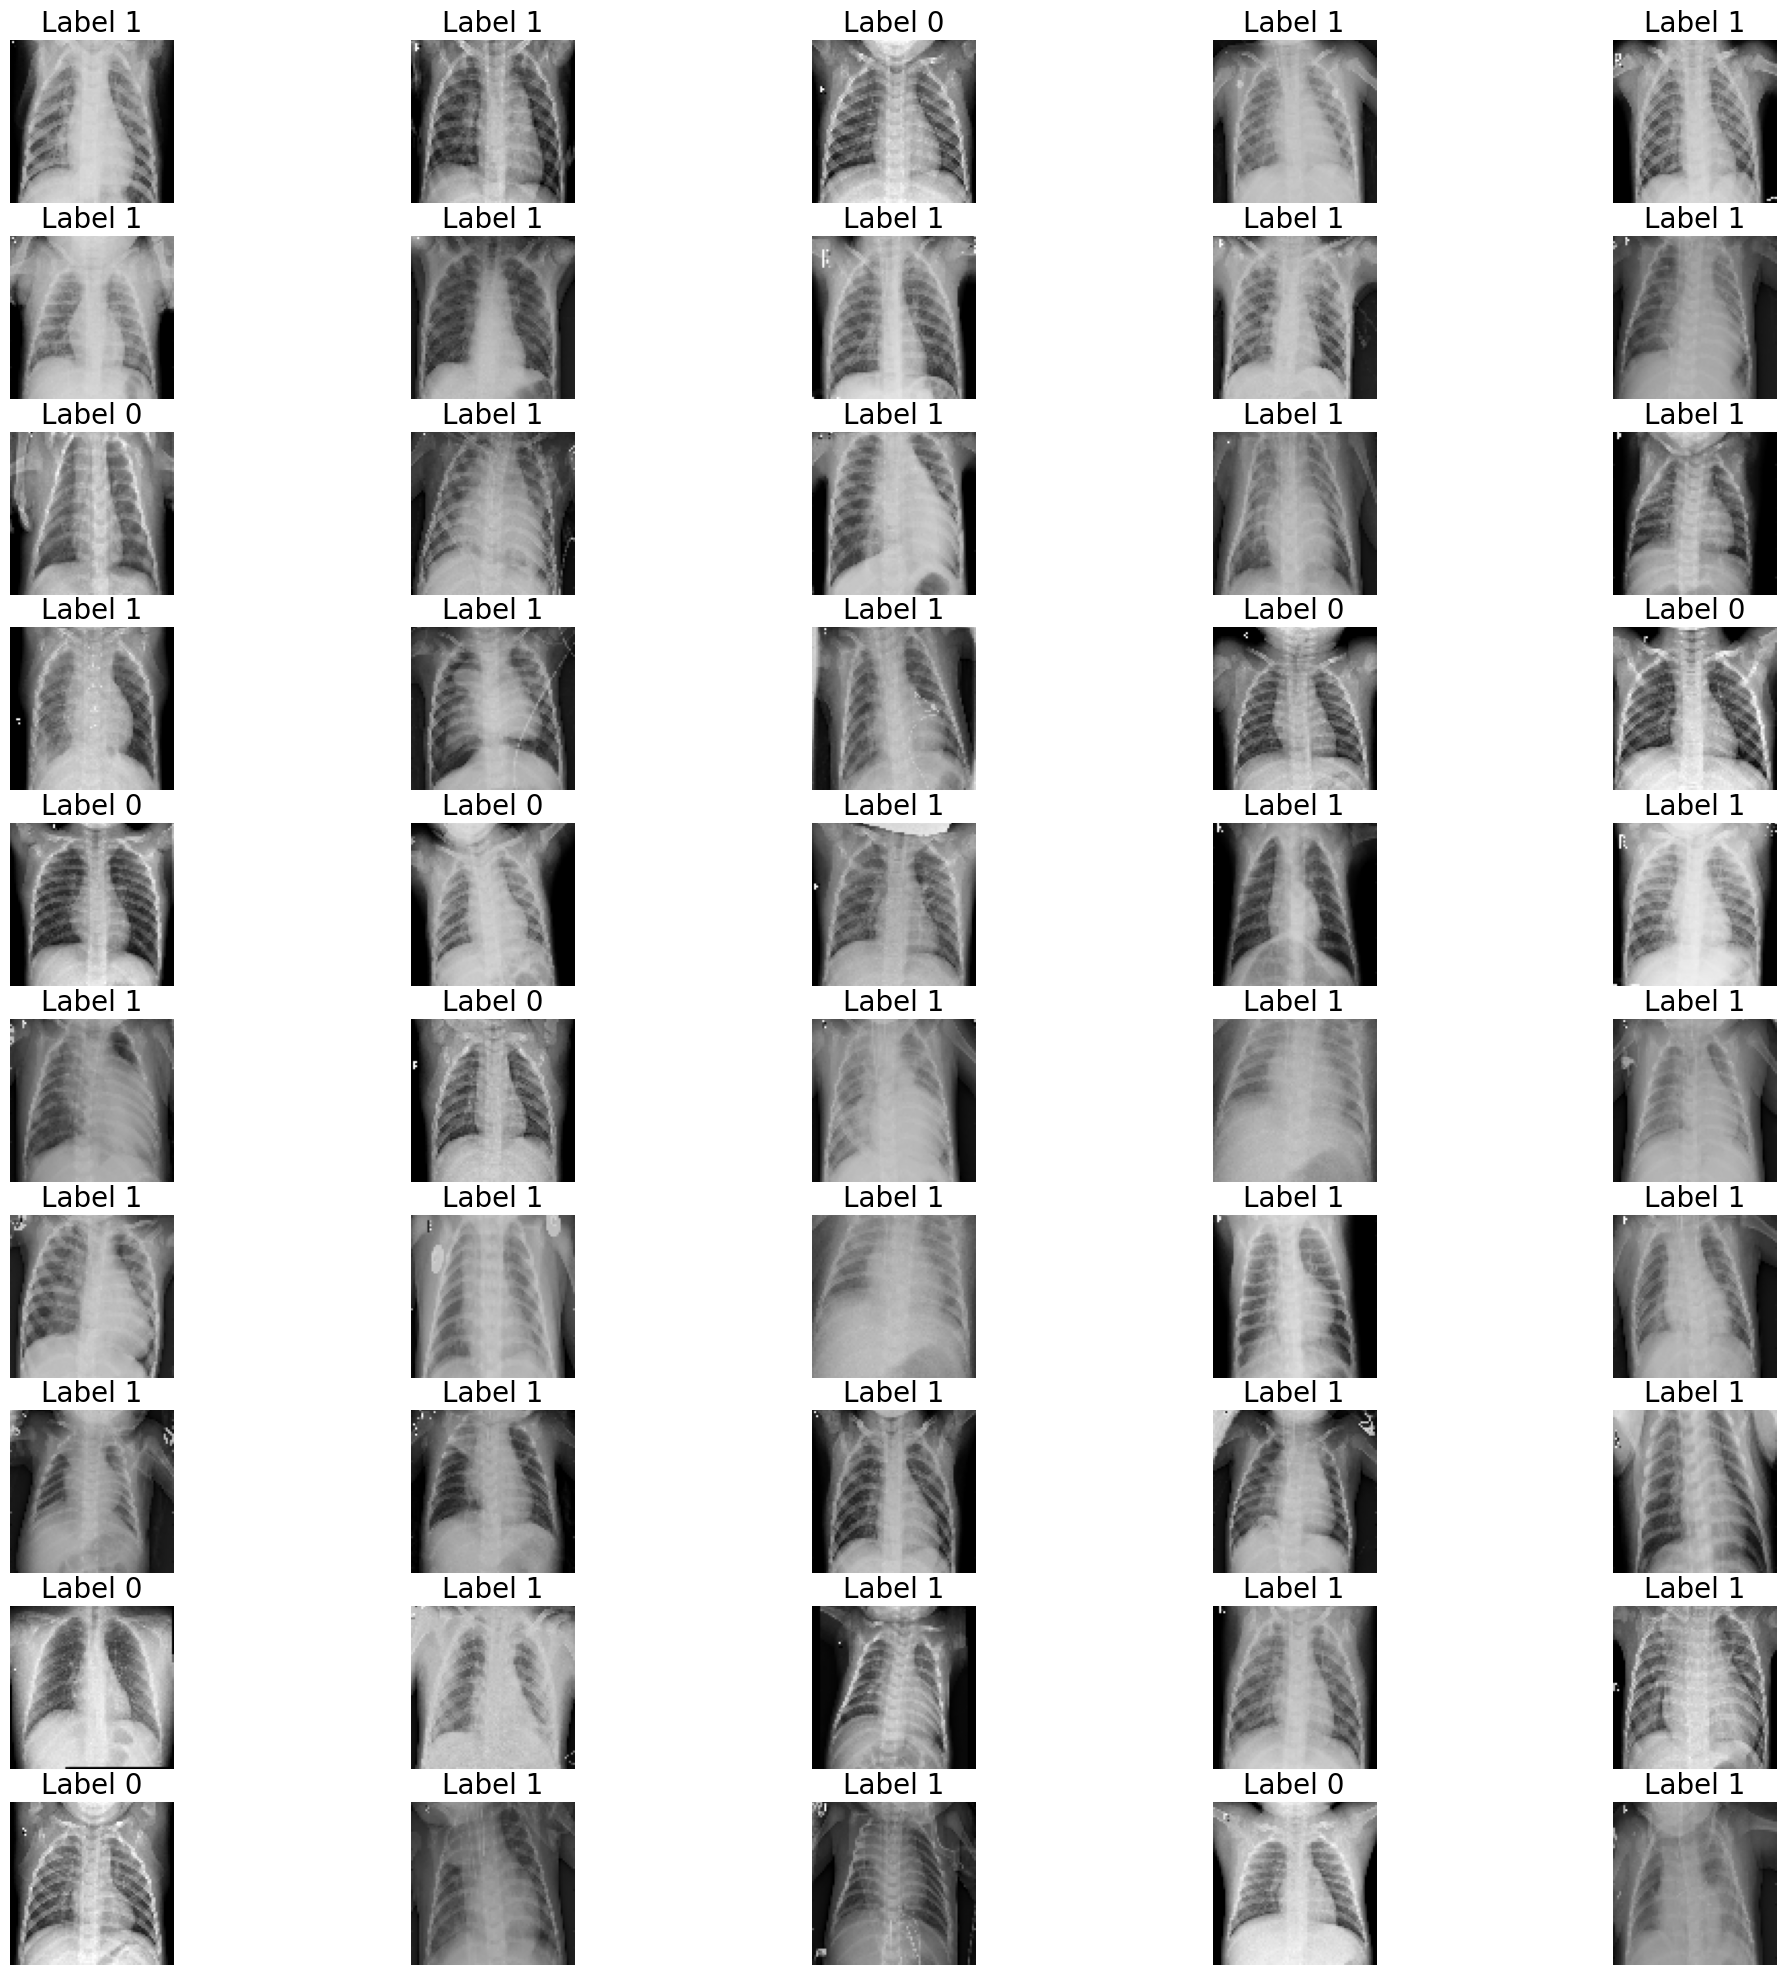

In [10]:

plt.figure(figsize=(25,25))
x = 1
for i in np.random.randint(0,len(images),50):
    plt.subplot(10, 5, x)
    plt.imshow(images[i])
    plt.title(f'Label {labels[i]}', fontsize=20)
    plt.axis('off')    
    x += 1

In [11]:
label=LabelEncoder()
labels=label.fit_transform(labels)
labels

array([0, 0, 1, ..., 1, 0, 1])

In [12]:
X_train, X_test2, y_train, y_test2 = train_test_split(images, labels, test_size=0.30, random_state=44, shuffle =True)
X_val, X_test, y_val, y_test = train_test_split(X_test2, y_test2, test_size=0.50, random_state=44, shuffle =True)
print('X_train shape is ' , X_train.shape)
print('X_val shape is ' , X_val.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_val shape is ' , y_val.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4099, 80, 80, 3)
X_val shape is  (878, 80, 80, 3)
X_test shape is  (879, 80, 80, 3)
y_train shape is  (4099,)
y_val shape is  (878,)
y_test shape is  (879,)


# CNN MODEL

In [13]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

# Load the VGG16 model, excluding the top dense layers
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(Size, Size, 3))

# Add custom layers on top of the VGG16 base model
x = Flatten()(base_model_vgg.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output_vgg = Dense(1, activation='sigmoid')(x)

# Checkpoint to save the best model and early stopping
checkpoint_cb = ModelCheckpoint("cnn_model.keras", save_best_only=True)
early_stopping_cb = EarlyStopping(patience=5, restore_best_weights=True)

# Create the model
model_vgg = Model(inputs=base_model_vgg.input, outputs=output_vgg)

# Freeze the layers of the VGG16 base model
for layer in base_model_vgg.layers:
    layer.trainable = False

# Compile the model with additional metrics
model_vgg.compile(optimizer='adam', loss='binary_crossentropy', 
                  metrics=['accuracy', 'Precision', 'Recall'])

# Train the model with early stopping
hist_vgg = model_vgg.fit(X_train, y_train, epochs=30, 
                         validation_data=(X_val, y_val), 
                         callbacks=[checkpoint_cb, early_stopping_cb])

# Evaluate the VGG16 model on the test set
score_vgg, acc_vgg = model_vgg.evaluate(X_test, y_test)
print('VGG16 Test Loss =', score_vgg)
print('VGG16 Test Accuracy =', acc_vgg)

# Classification Report and Confusion Matrix for more insights
y_pred = model_vgg.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Epoch 1/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - Precision: 0.8772 - Recall: 0.9442 - accuracy: 0.8602 - loss: 0.3249 - val_Precision: 0.9380 - val_Recall: 0.9618 - val_accuracy: 0.9271 - val_loss: 0.1746
Epoch 2/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - Precision: 0.9471 - Recall: 0.9570 - accuracy: 0.9314 - loss: 0.1710 - val_Precision: 0.9314 - val_Recall: 0.9714 - val_accuracy: 0.9282 - val_loss: 0.1747
Epoch 3/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 188s 1s/step - Precision: 0.9556 - Recall: 0.9659 - accuracy: 0.9425 - loss: 0.1522 - val_Precision: 0.9469 - val_Recall: 0.9634 - val_accuracy: 0.9351 - val_loss: 0.1487
Epoch 4/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - Precision: 0.9639 - Recall: 0.9692 - accuracy: 0.9507 - loss: 0.1299 - val_Precision: 0.9558 - val_Recall: 0.9618 - val_accuracy: 0.9408 - val_loss: 0.1506
Epoch 5/30
129/129 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - Precision: 0.9683 - Recall: 0.9736 - accuracy: 0.9571 - loss: 0.1196 - val_Precision: 0.9862 - val_Re

ValueError: too many values to unpack (expected 2)

In [14]:
# Evaluate the VGG16 model on the test set
results = model_vgg.evaluate(X_test, y_test)
print(f'VGG16 Test Loss: {results[0]}')  # Loss
print(f'VGG16 Test Accuracy: {results[1]}')  # Accuracy
print(f'VGG16 Test Precision: {results[2]}')  # Precision
print(f'VGG16 Test Recall: {results[3]}')  # Recall

28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - Precision: 0.9642 - Recall: 0.9655 - accuracy: 0.9480 - loss: 0.1754
VGG16 Test Loss: 0.15558788180351257
VGG16 Test Accuracy: 0.9522184133529663
VGG16 Test Precision: 0.9648854732513428
VGG16 Test Recall: 0.9708141088485718


In [15]:
# Save the final model to 'model.h5'
model_vgg.save('model.h5')

In [16]:
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 80, 80, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 10, 10, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 5, 5, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           12

 Total params: 16,387,397 (62.51 MB)

 Trainable params: 557,569 (2.13 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,115,140 (4.25 MB)